# Лабораторная работа №2: Обработка признаков (часть 1)
**Выполнил:** Бибиков Павел, ИУ5-22М

## Цель лабораторной работы:
Изучение способов предварительной обработки данных для дальнейшего формирования моделей машинного обучения.

## Задание:
1. Выбрать набор данных (датасет).
2. Для выбранного датасета решить следующие задачи:
    * устранение пропусков в данных (при необходимости создать их искусственно);
    * кодирование категориальных признаков;
    * нормализация числовых признаков.

## Используемый датасет:
**"Students Performance in Exams" (`StudentsPerformance.csv`)**: Содержит информацию об успеваемости студентов по математике, чтению и письму, а также демографические и социальные факторы.

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки для лучшего отображения
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Для кодирования и нормализации
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

In [2]:
try:
    df_original = pd.read_csv('StudentsPerformance.csv')
except FileNotFoundError:
    print("Файл 'StudentsPerformance.csv' не найден. Пожалуйста, скачайте его и поместите в нужную директорию.")
    # Для примера создадим DataFrame с похожей структурой, если файл не найден (на случай если запускается без файла)
    data_placeholder = {
        'gender': ['female', 'male', 'female', 'male', 'female'] * 200,
        'race/ethnicity': ['group B', 'group C', 'group A', 'group D', 'group E'] * 200,
        'parental level of education': ["bachelor's degree", "some college", "master's degree", "associate's degree", "high school"] * 200,
        'lunch': ['standard', 'free/reduced', 'standard', 'free/reduced', 'standard'] * 200,
        'test preparation course': ['none', 'completed', 'none', 'completed', 'none'] * 200,
        'math score': np.random.randint(0, 101, 1000),
        'reading score': np.random.randint(0, 101, 1000),
        'writing score': np.random.randint(0, 101, 1000)
    }
    df_original = pd.DataFrame(data_placeholder)
    print("Создан демонстрационный DataFrame.")

# Преобразуем названия колонок для удобства (как в ЛР1)
df_original.columns = df_original.columns.str.replace(' ', '_') \
                                     .str.replace('/', '_') \
                                     .str.replace(r'[\(\)]', '', regex=True)

print("Исходные данные (первые 5 строк):")
print(df_original.head())
print("\nИнформация о типах данных и пропусках в исходном датасете:")
df_original.info()

Исходные данные (первые 5 строк):
   gender race_ethnicity parental_level_of_education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test_preparation_course  math_score  reading_score  writing_score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75  

Информация о типах данных и пропусках в исходном датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0

## 1. Устранение пропусков в данных

Как мы знаем из предыдущей работы, в нашем датасете нет пропущенных значений. Чтобы продемонстрировать методы их обработки, мы искусственно внесем пропуски в копию нашего датафрейма.

In [3]:
# ... (код до Шага 1.1) ...

# Создаем копию для экспериментов с пропусками
df_with_missing = df_original.copy()

# Искусственно создадим пропуски
# Например, в 'math_score' (числовой признак) и 'parental_level_of_education' (категориальный)
# Внесем примерно 5% пропусков в 'math_score'
missing_percentage_math = 0.05
n_missing_math = int(len(df_with_missing) * missing_percentage_math)
missing_indices_math = np.random.choice(df_with_missing.index, n_missing_math, replace=False)
df_with_missing.loc[missing_indices_math, 'math_score'] = np.nan

# Внесем примерно 7% пропусков в 'parental_level_of_education'
missing_percentage_parental = 0.07
n_missing_parental = int(len(df_with_missing) * missing_percentage_parental)
missing_indices_parental = np.random.choice(df_with_missing.index, n_missing_parental, replace=False)
df_with_missing.loc[missing_indices_parental, 'parental_level_of_education'] = np.nan

print("\nИнформация о пропусках после искусственного внесения:")
print(df_with_missing.isnull().sum())

# print("\nПервые 5 строк данных с пропусками:") # Можно закомментировать, если вывод большой
# print(df_with_missing.head())


Информация о пропусках после искусственного внесения:
gender                          0
race_ethnicity                  0
parental_level_of_education    70
lunch                           0
test_preparation_course         0
math_score                     50
reading_score                   0
writing_score                   0
dtype: int64


### 1.1. Обработка пропусков в числовых признаках (math_score)
Для числовых признаков популярные стратегии - замена средним, медианой или модой.


Пропуски в math_score после заполнения медианой: 0


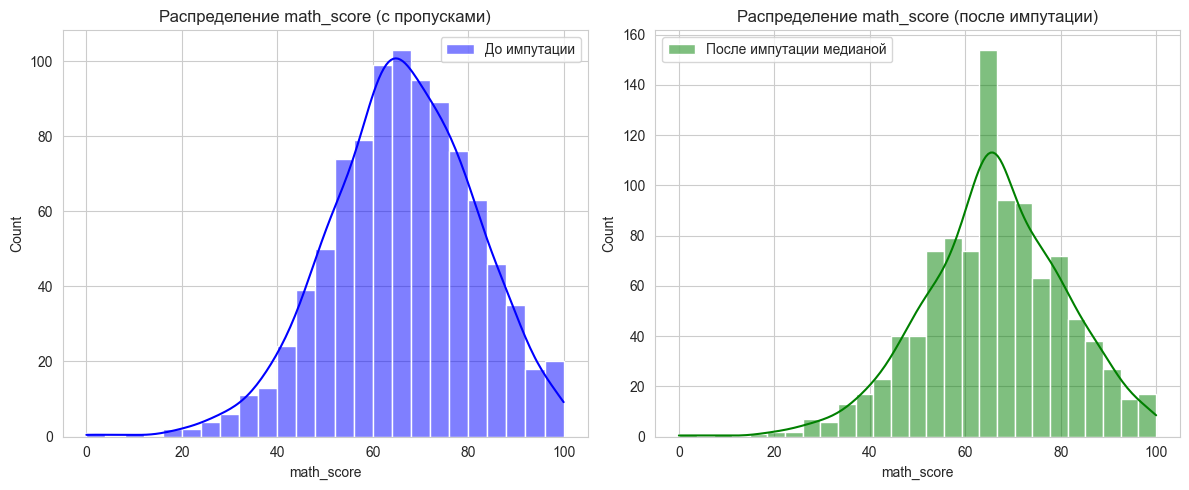

In [4]:
# Создадим копию датафрейма для обработки пропусков
df_imputed = df_with_missing.copy()

# --- Заполнение пропусков в 'math_score' ---

# Способ 1: Заполнение средним значением (показан для примера, но используем медиану)
# imputer_mean = SimpleImputer(strategy='mean')
# df_imputed['math_score_mean_imputed'] = imputer_mean.fit_transform(df_imputed[['math_score']]).ravel() # ИСПРАВЛЕНО .ravel()
# print("\nПропуски в math_score после заполнения средним:", df_imputed['math_score_mean_imputed'].isnull().sum())

# Способ 2: Заполнение медианой (более устойчиво к выбросам)
imputer_median = SimpleImputer(strategy='median')
# Передаем DataFrame с одной колонкой, fit_transform вернет 2D массив, который нужно "расплющить"
df_imputed['math_score'] = imputer_median.fit_transform(df_imputed[['math_score']]).ravel() # ИСПРАВЛЕНО .ravel()
print("\nПропуски в math_score после заполнения медианой:", df_imputed['math_score'].isnull().sum())
# Для вывода заполненных значений, нужно сначала найти индексы пропусков в оригинальном df_with_missing
# print("Заполненные значения (пример):", df_imputed.loc[missing_indices_math, 'math_score'].head()) # Более корректный вывод


# Визуализация распределения до и после импутации медианой
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_with_missing['math_score'], kde=True, color='blue', label='До импутации')
plt.title('Распределение math_score (с пропусками)')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(df_imputed['math_score'], kde=True, color='green', label='После импутации медианой')
plt.title('Распределение math_score (после импутации)')
plt.legend()
plt.tight_layout()
plt.show()

Мы заполнили пропуски в math_score медианным значением. Этот метод был выбран, так как медиана менее чувствительна к выбросам по сравнению со средним. Графики показывают, что основная форма распределения сохранилась, но "провал" на месте пропусков был заполнен.

### 1.2. Обработка пропусков в категориальных признаках (parental_level_of_education)
Для категориальных признаков часто используют заполнение модой (наиболее частым значением) или константой.


Пропуски в parental_level_of_education после заполнения модой: 0


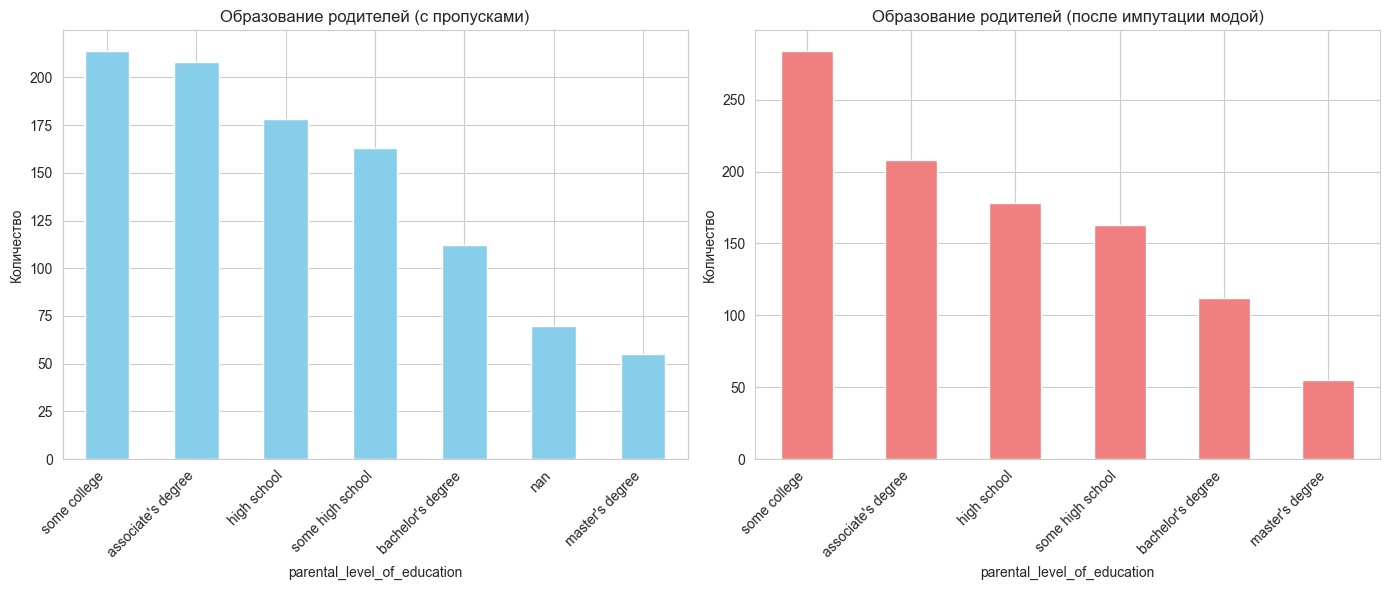


Общее количество пропусков в df_imputed после всех импутаций:
0


In [5]:
# --- Заполнение пропусков в 'parental_level_of_education' ---

# Способ 1: Заполнение модой
imputer_mode = SimpleImputer(strategy='most_frequent')
df_imputed['parental_level_of_education'] = imputer_mode.fit_transform(df_imputed[['parental_level_of_education']]).ravel() # ИСПРАВЛЕНО .ravel()
print("\nПропуски в parental_level_of_education после заполнения модой:", df_imputed['parental_level_of_education'].isnull().sum())
# print("Заполненные значения (пример):", df_imputed.loc[missing_indices_parental, 'parental_level_of_education'].head()) # Более корректный вывод


# Визуализация до и после импутации модой
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
# Учитываем, что value_counts на данных с NaN может вести себя по-разному в зависимости от dropna
df_with_missing['parental_level_of_education'].value_counts(dropna=False).plot(kind='bar', color='skyblue')
plt.title('Образование родителей (с пропусками)')
plt.ylabel('Количество')
plt.xticks(rotation=45, ha='right')


plt.subplot(1, 2, 2)
df_imputed['parental_level_of_education'].value_counts().plot(kind='bar', color='lightcoral')
plt.title('Образование родителей (после импутации модой)')
plt.ylabel('Количество')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Проверим, что все пропуски заполнены в df_imputed
print("\nОбщее количество пропусков в df_imputed после всех импутаций:")
print(df_imputed.isnull().sum().sum())

Пропуски в parental_level_of_education были заменены наиболее часто встречающимся значением (модой). Это простой и часто эффективный метод для категориальных данных. Столбчатые диаграммы показывают, как изменилось количество в категории, соответствующей моде (она увеличилась на число замененных пропусков).

Вместо df_imputed для последующих шагов будем использовать df_original, так как там нет пропусков, и мы выполнили демонстрацию обработки. Если бы в вашем реальном датасете были пропуски, вы бы продолжили работу с df_imputed. Для чистоты эксперимента в следующих шагах работаем с исходными данными без искусственных пропусков.

In [6]:
df_processed = df_original.copy() # Начинаем обработку с "чистого" датасета

## 2. Кодирование категориальных признаков
Категориальные признаки нужно преобразовать в числовой формат для большинства моделей машинного обучения.

In [7]:
# Определим категориальные и числовые признаки
categorical_cols = df_processed.select_dtypes(include='object').columns
numerical_cols = df_processed.select_dtypes(include=np.number).columns

print("Категориальные колонки:", list(categorical_cols))
print("Числовые колонки:", list(numerical_cols))

Категориальные колонки: ['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course']
Числовые колонки: ['math_score', 'reading_score', 'writing_score']


### 2.1. Label Encoding
Подходит для порядковых признаков или когда количество уникальных значений невелико, и мы используем модели, которые могут справиться с таким кодированием (например, деревья решений). Для примера применим к parental_level_of_education, предполагая некую иерархию.

In [8]:
# Создаем копию для кодирования
df_encoded = df_processed.copy()

# Label Encoding для 'parental_level_of_education'
# Предположим, что есть некий порядок (хотя это спорно, но для демонстрации)
# high school < some high school < some college < associate's degree < bachelor's degree < master's degree
# Для корректного Label Encoding с порядком лучше использовать pd.Categorical или OrdinalEncoder
# Но для простоты и если порядок не строгий, LabelEncoder тоже подойдет.

le = LabelEncoder()
df_encoded['parental_education_label_encoded'] = le.fit_transform(df_encoded['parental_level_of_education'])

print("\n'parental_level_of_education' после Label Encoding:")
print(df_encoded[['parental_level_of_education', 'parental_education_label_encoded']].head())
print("Уникальные значения и их коды:", df_encoded[['parental_level_of_education', 'parental_education_label_encoded']].drop_duplicates().sort_values('parental_education_label_encoded'))


'parental_level_of_education' после Label Encoding:
  parental_level_of_education  parental_education_label_encoded
0           bachelor's degree                                 1
1                some college                                 4
2             master's degree                                 3
3          associate's degree                                 0
4                some college                                 4
Уникальные значения и их коды:    parental_level_of_education  parental_education_label_encoded
3           associate's degree                                 0
0            bachelor's degree                                 1
8                  high school                                 2
2              master's degree                                 3
1                 some college                                 4
15            some high school                                 5


Признак parental_level_of_education был преобразован: каждому уникальному текстовому значению присвоено числовое. Например, "bachelor's degree" могло стать 0, "master's degree" - 1 и т.д. Важно помнить, что такое кодирование вносит искусственный порядок, который может быть неправильно интерпретирован некоторыми моделями (например, линейными).

### 2.2. One-Hot Encoding
Подходит для номинальных признаков (где нет порядка) и когда количество уникальных категорий не слишком велико. Создает новые бинарные (0 или 1) столбцы для каждой категории.

In [9]:
# One-Hot Encoding для остальных категориальных признаков
# 'gender', 'race_ethnicity', 'lunch', 'test_preparation_course'
cols_for_ohe = ['gender', 'race_ethnicity', 'lunch', 'test_preparation_course']

# Используем pd.get_dummies для простоты
df_encoded = pd.get_dummies(df_encoded, columns=cols_for_ohe, prefix=cols_for_ohe, drop_first=True)
# drop_first=True помогает избежать мультиколлинеарности (удаляет одну избыточную категорию)

print("\nДанные после One-Hot Encoding (первые 5 строк):")
print(df_encoded.head())
print("\nНовые колонки:", df_encoded.columns)

# Удалим исходную колонку 'parental_level_of_education', так как мы ее закодировали через LabelEncoder
# (или можно было бы ее тоже через OHE, если не видим порядка)
if 'parental_level_of_education' in df_encoded.columns:
    df_encoded = df_encoded.drop('parental_level_of_education', axis=1)

print("\nФинальный вид данных после кодирования категориальных признаков:")
df_encoded.info()


Данные после One-Hot Encoding (первые 5 строк):
  parental_level_of_education  math_score  reading_score  writing_score  \
0           bachelor's degree          72             72             74   
1                some college          69             90             88   
2             master's degree          90             95             93   
3          associate's degree          47             57             44   
4                some college          76             78             75   

   parental_education_label_encoded  gender_male  race_ethnicity_group B  \
0                                 1        False                    True   
1                                 4        False                   False   
2                                 3        False                    True   
3                                 0         True                   False   
4                                 4         True                   False   

   race_ethnicity_group C  race_ethnicity_g

Признаки gender, race_ethnicity, lunch, test_preparation_course были преобразованы с помощью One-Hot Encoding. Для каждого из них были созданы новые столбцы. Например, для gender (male, female) после drop_first=True останется один столбец, например gender_male, где 1 означает "male", а 0 - "female". Это предотвращает избыточность информации и подходит для большинства алгоритмов.

## 3. Нормализация числовых признаков
Нормализация (или стандартизация) приводит числовые признаки к единому масштабу. Это важно для алгоритмов, чувствительных к масштабу признаков (например, KNN, SVM, нейронные сети).

In [10]:
# Числовые признаки для нормализации: 'math_score', 'reading_score', 'writing_score'
# 'parental_education_label_encoded' уже является числовым, но это закодированная категория, ее обычно не масштабируют так же.
# Однако, если бы это был истинно порядковый числовой признак с большим разбросом, его можно было бы включить.
# В нашем случае, баллы - главные кандидаты.

numerical_features_to_scale = ['math_score', 'reading_score', 'writing_score']
df_scaled = df_encoded.copy() # Используем датафрейм после кодирования категорий

### 3.1. StandardScaler (Стандартизация)
Преобразует данные так, чтобы они имели среднее значение 0 и стандартное отклонение 1.


Данные после StandardScaler (описательная статистика для масштабированных признаков):
         math_score  reading_score  writing_score
count  1.000000e+03   1.000000e+03   1.000000e+03
mean   8.704149e-17   2.167155e-16  -1.350031e-16
std    1.000500e+00   1.000500e+00   1.000500e+00
min   -4.360728e+00  -3.574960e+00  -3.822345e+00
25%   -5.997164e-01  -6.968462e-01  -6.784278e-01
50%   -5.872457e-03   5.694554e-02   6.228578e-02
75%    7.199368e-01   6.736842e-01   7.206978e-01
max    2.237538e+00   2.112741e+00   2.103363e+00


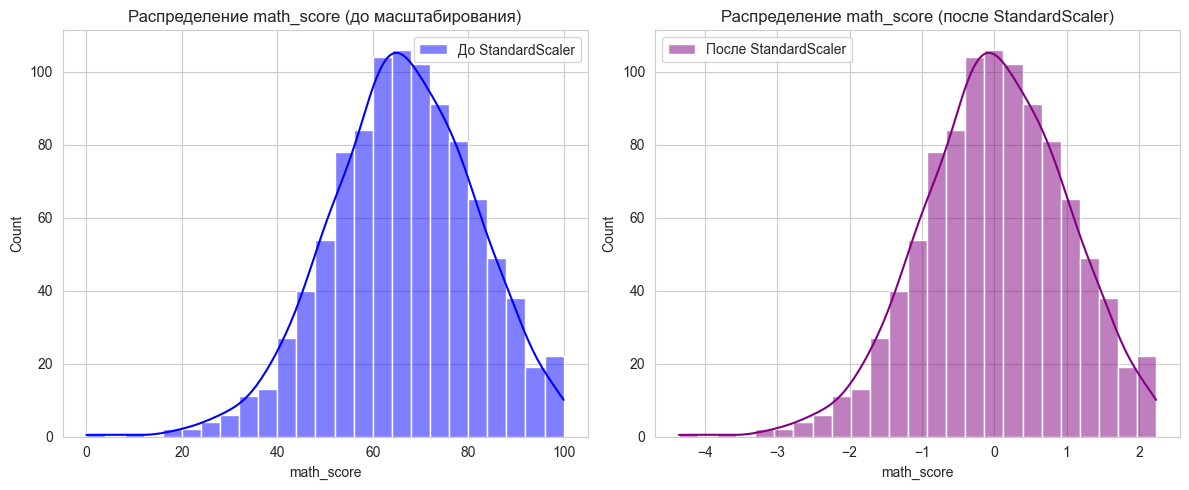

In [11]:
scaler_standard = StandardScaler()
df_scaled[numerical_features_to_scale] = scaler_standard.fit_transform(df_scaled[numerical_features_to_scale])

print("\nДанные после StandardScaler (описательная статистика для масштабированных признаков):")
print(df_scaled[numerical_features_to_scale].describe())

# Визуализация распределения 'math_score' до и после StandardScaler
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_encoded['math_score'], kde=True, color='blue', label='До StandardScaler') # Используем df_encoded для "до"
plt.title('Распределение math_score (до масштабирования)')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(df_scaled['math_score'], kde=True, color='purple', label='После StandardScaler')
plt.title('Распределение math_score (после StandardScaler)')
plt.legend()
plt.tight_layout()
plt.show()

После применения StandardScaler числовые признаки (math_score, reading_score, writing_score) теперь имеют среднее значение, близкое к 0, и стандартное отклонение, близкое к 1. Форма распределения признаков сохраняется, но их масштаб изменяется. Это полезно для алгоритмов, которые предполагают, что данные центрированы вокруг нуля и имеют одинаковую дисперсию.

### 3.2. MinMaxScaler (Масштабирование к диапазону)
Масштабирует данные в заданный диапазон, обычно [0, 1].


Данные после MinMaxScaler (описательная статистика для масштабированных признаков):
        math_score  reading_score  writing_score
count  1000.000000    1000.000000    1000.000000
mean      0.660890       0.628542       0.645044
std       0.151631       0.175906       0.168841
min       0.000000       0.000000       0.000000
25%       0.570000       0.506024       0.530556
50%       0.660000       0.638554       0.655556
75%       0.770000       0.746988       0.766667
max       1.000000       1.000000       1.000000


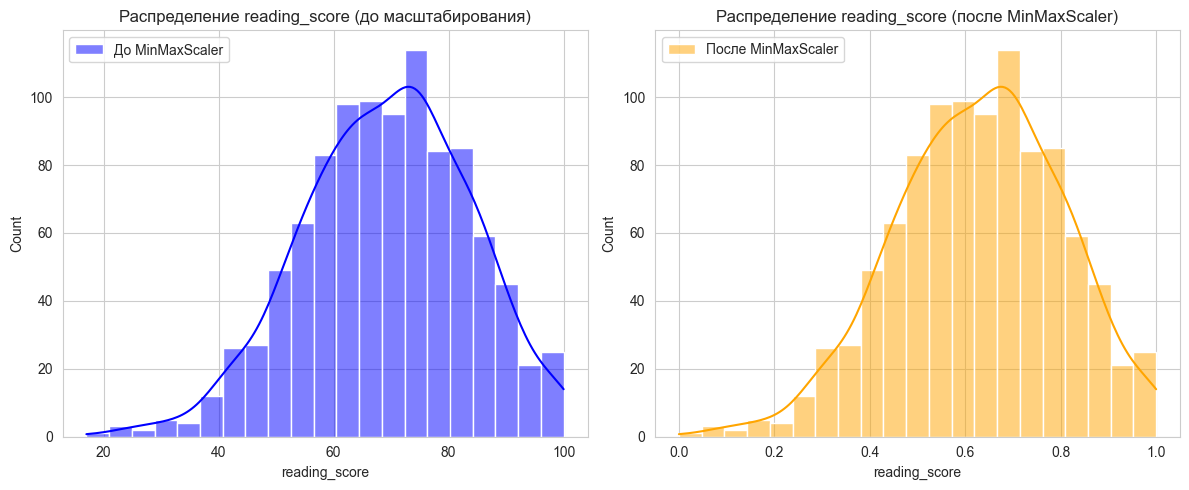

In [12]:
# Для демонстрации MinMaxScaler вернемся к данным перед StandardScaler
# или применим к другим колонкам, если бы они были.
# В данном случае, чтобы не путаться, создадим новую копию df_encoded.
df_minmax_scaled = df_encoded.copy()

scaler_minmax = MinMaxScaler()
df_minmax_scaled[numerical_features_to_scale] = scaler_minmax.fit_transform(df_minmax_scaled[numerical_features_to_scale])

print("\nДанные после MinMaxScaler (описательная статистика для масштабированных признаков):")
print(df_minmax_scaled[numerical_features_to_scale].describe())


# Визуализация распределения 'reading_score' до и после MinMaxScaler
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_encoded['reading_score'], kde=True, color='blue', label='До MinMaxScaler') # Используем df_encoded для "до"
plt.title('Распределение reading_score (до масштабирования)')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(df_minmax_scaled['reading_score'], kde=True, color='orange', label='После MinMaxScaler')
plt.title('Распределение reading_score (после MinMaxScaler)')
plt.legend()
plt.tight_layout()
plt.show()

После применения MinMaxScaler все значения в масштабированных признаках находятся в диапазоне от 0 до 1. Минимальное значение в каждом признаке стало 0, а максимальное - 1. Этот тип масштабирования полезен, когда требуется, чтобы признаки имели строго ограниченный диапазон, например, для некоторых типов нейронных сетей.

In [13]:
print("\nФинальный вид датафрейма после всех преобразований (пример с StandardScaler):")
print(df_scaled.head())
df_scaled.info()


Финальный вид датафрейма после всех преобразований (пример с StandardScaler):
   math_score  reading_score  writing_score  parental_education_label_encoded  \
0    0.390024       0.193999       0.391492                                 1   
1    0.192076       1.427476       1.313269                                 4   
2    1.577711       1.770109       1.642475                                 3   
3   -1.259543      -0.833899      -1.583744                                 0   
4    0.653954       0.605158       0.457333                                 4   

   gender_male  race_ethnicity_group B  race_ethnicity_group C  \
0        False                    True                   False   
1        False                   False                    True   
2        False                    True                   False   
3         True                   False                   False   
4         True                   False                    True   

   race_ethnicity_group D  race_ethni